In [25]:
import os
import sys
import torch
import numpy as np
import SimpleITK as sitk

from PIL import Image

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pyradiomics_api import pyradiomics_glcm
from diffglcm import DiffGLCM
from kdeglcm import compute_glcm_kde
from matplotlib import pyplot as plt
from pyradiomics_api import pyradiomics_glcm

(64, 64)


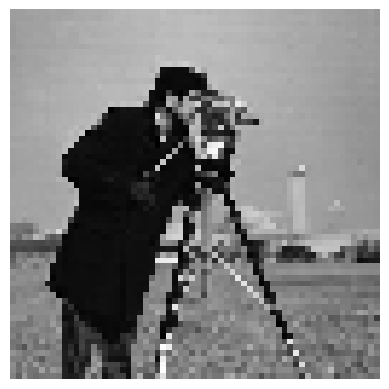

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Cameraman.png and convert to numpy array with values in range 0-1
img = Image.open(r'../../Cameraman.png').convert('L')  # Convert to grayscale
x = np.array(img) / 255.0
x = x[::4, ::4]

# Display the image
plt.imshow(x, cmap='gray')
plt.axis('off')
print(x.shape)

x = np.repeat(x[np.newaxis, :, :], 100, axis=0)

In [27]:
import time
from tqdm import tqdm

start_time = time.time()
_ = compute_glcm_kde(x, binNum=64, delta_r=1, delta_c=1)
print("KDE GLCM time: ", time.time() - start_time)

diffglcm = DiffGLCM(
    image_size=x.shape[-1],  # Assuming square image
    low_bound=0,
    high_bound=1,
    Ng=64,
    alpha=10,
    differentiable=True
).to(device)

image_tensor = torch.from_numpy(x).to(device).unsqueeze(1)
start_time = time.time()
_ = diffglcm(image_tensor, offset_r=1, offset_c=1)
print("DiffGLCM time: ", time.time() - start_time)

# pyradiomics
start_time = time.time()
for i in range(x.shape[0]):
    image_array = x[i, :, :].astype(np.float32)
    low_bound = 0
    high_bound = 1
    bin_count = 64
    symmetricalGLCM = False
    angle = (1, 1)
    _ = pyradiomics_glcm(image_array, low_bound, high_bound, bin_count, symmetricalGLCM, angle)
print("PyRadiomics GLCM time: ", time.time() - start_time)


KDE GLCM time:  0.24322271347045898
DiffGLCM time:  0.04404044151306152
PyRadiomics GLCM time:  1.9931252002716064
